In [1]:
# Load required packages 
import math
from collections import Counter
import itertools
import matplotlib.gridspec as gridspec
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import pandas as pd
import glob
import statistics as stats
import pandas as pd
import pickle
from scipy import signal
import scipy
import seaborn as sns
from os import listdir
from os.path import isfile, join
import re
from chart_studio import plotly as py

from astropy.coordinates import Angle
import plotly.graph_objs as go
import plotly.offline as pyo
from astroquery.simbad import Simbad
import plotly.figure_factory as ff
import astropy.coordinates as coord
import astropy.units as u
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from scipy.signal import find_peaks
from matplotlib.colors import LogNorm
from collections import Counter
import datetime
import h5py
from scipy.stats import pearsonr   
from tqdm.auto import tqdm
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
import traceback
from matplotlib import pyplot as plt, cm
from matplotlib import colors
import hdf5plugin
import pickle
%matplotlib inline

print("All packages imported!")

/datax/scratch/calebp/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

/tmp/ipykernel_107901/221726504.py:43: MatplotlibDeprecationWarning:

mplDeprecation was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use matplotlib.MatplotlibDeprecationWarning instead.



All packages imported!


## Functions

In [2]:
def plot_candidates(hf1,hf2,hf3,hf4,hf5,hf6,lower,upper,file_ON,foff,fch1):
    obs1 = np.squeeze(hf1['data'][:,:,lower:upper],axis=1)
    obs2 = np.squeeze(hf2['data'][:,:,lower:upper],axis=1)
    obs3 = np.squeeze(hf3['data'][:,:,lower:upper],axis=1)
    obs4 = np.squeeze(hf4['data'][:,:,lower:upper],axis=1)
    obs5 = np.squeeze(hf5['data'][:,:,lower:upper],axis=1)
    obs6 = np.squeeze(hf6['data'][:,:,lower:upper],axis=1)

    print(obs1)

    cadence_max = np.max([np.max(obs1),np.max(obs2),np.max(obs3),np.max(obs4),np.max(obs5),np.max(obs6)])
    
    obs1_values = (obs1/cadence_max).flatten()
    obs2_values = (obs2/cadence_max).flatten()
    obs3_values = (obs3/cadence_max).flatten()
    obs4_values = (obs4/cadence_max).flatten()
    obs5_values = (obs5/cadence_max).flatten()
    obs6_values = (obs6/cadence_max).flatten()


    k1 = scipy.stats.kurtosis(obs1_values)
    k2 = scipy.stats.kurtosis(obs2_values)
    k3 = scipy.stats.kurtosis(obs3_values)
    k4 = scipy.stats.kurtosis(obs4_values)
    k5 = scipy.stats.kurtosis(obs5_values)
    k6 = scipy.stats.kurtosis(obs6_values)


    obs1 = obs1/np.max(obs1)
    obs2 = obs2/np.max(obs2)
    obs3 = obs3/np.max(obs3)
    obs4 = obs4/np.max(obs4)
    obs5 = obs5/np.max(obs5)
    obs6 = obs6/np.max(obs6)



    full_cadence = np.squeeze([np.concatenate((obs1,obs2,obs3,obs4,obs5,obs6))])


    # plot the waterfall
    fig, axs = plt.subplots(6,figsize=(5, 7))
    axs[0].imshow(obs1,aspect='auto',extent=[-(2048*foff*10**3),(2048*foff*10**3),300,0])
    axs[1].imshow(obs2,aspect='auto',extent=[-(2048*foff*10**3),(2048*foff*10**3),300,0])
    axs[2].imshow(obs3,aspect='auto',extent=[-(2048*foff*10**3),(2048*foff*10**3),300,0])
    axs[3].imshow(obs4,aspect='auto',extent=[-(2048*foff*10**3),(2048*foff*10**3),300,0])
    axs[4].imshow(obs5,aspect='auto',extent=[-(2048*foff*10**3),(2048*foff*10**3),300,0])
    axs[5].imshow(obs6,aspect='auto',extent=[-(2048*foff*10**3),(2048*foff*10**3),300,0])
    plt.subplots_adjust(hspace=0)
    center_freq = fch1+foff*(lower)    
    name = file_ON.split('/')[-1]
    name = name.split("_")[2:]
    plt.suptitle(' '.join(name),fontsize=10)
    plt.xlabel(f"Relative Frequency [kHz] from {fch1-2048*np.round(-foff,9)} Mhz")
    plt.ylabel("Time [s]")
    plt.show()

    
    return k_score

def filter_zero_drift(obs1,obs2,obs3,obs4,obs5,obs6,filtering_level):
    # checking if there are lots of zero drift signals in OFF observations, or ON and OFF observations
        
    # plot the integrated frequency
    obs1_int = obs1.sum(axis=0)
    obs2_int = obs2.sum(axis=0)
    obs3_int = obs3.sum(axis=0)
    obs4_int = obs4.sum(axis=0)
    obs5_int = obs5.sum(axis=0)
    obs6_int = obs6.sum(axis=0)

    obs_sums = [obs1_int,obs2_int,obs3_int,obs4_int,obs5_int,obs6_int]


    whole_sum = obs1_int+obs2_int+obs3_int+obs4_int+obs5_int+obs6_int
    off_sum = [obs2_int,obs4_int,obs6_int]
        
    on_sum_list = [obs1_int,obs3_int,obs5_int]
    on_sum_sum = obs1_int+obs3_int+obs5_int

    if filtering_level < 3:
        whole_sum = off_sum

    all_peaks = []
    all_peak_freqs = []

    for i,obs_int in enumerate(on_sum_list):
        obs_data = obs_int/np.max(obs_int)
        sigma_mult = scipy.stats.median_abs_deviation(obs_data)
        peaks, properties = find_peaks(obs_data, prominence=10*sigma_mult, width=1,distance=10)
        freqs = np.arange(0,len(whole_sum),1)

        all_peak_freqs.append(freqs[peaks])
        # plt.plot(freqs,obs_data)
        # plt.scatter(freqs[peaks],obs_data[peaks],color='orange',s=50)
        # plt.show()

    for i,obs_int in enumerate([on_sum_sum]):
        obs_data = obs_int/np.max(obs_int)
        sigma_mult = scipy.stats.median_abs_deviation(obs_data)
        peaks, properties = find_peaks(obs_data, prominence=10*sigma_mult, width=1,distance=10)
        freqs = np.arange(0,len(whole_sum),1)

        all_peaks.append(len(peaks))

        # plt.plot(freqs,obs_data)
        # plt.scatter(freqs[peaks],obs_data[peaks],color='orange',s=50)
        # plt.show()

    peak_drift_1 = []
    peak_drift_2 = []
    peak_drift_3 = []
    print('peaks',all_peak_freqs[0],all_peak_freqs[1],all_peak_freqs[2])


    if len(all_peak_freqs[1]) != 0:
        peak_drift_1 = find_closest_elements(all_peak_freqs[0],all_peak_freqs[1])
    if len(all_peak_freqs[2]) != 0:
        peak_drift_2 = find_closest_elements(all_peak_freqs[1],all_peak_freqs[2])
    if len(all_peak_freqs[2]) != 0:
        peak_drift_3 = find_closest_elements(all_peak_freqs[0],all_peak_freqs[2])


    return all_peaks[-1], peak_drift_1,peak_drift_2,peak_drift_3

def find_closest_elements(a, b):
    result = []
    
    for element_a in a:
        closest_element_b = min(b, key=lambda x: abs(x - element_a))
        difference = abs(element_a - closest_element_b)
        result.append(difference)
    
    return result


def get_snr_of_slice(a):


    data_slice = np.copy(a)
    data_slice /= np.max(data_slice)

    data_slice -= np.median(data_slice)
    
    mad = scipy.stats.median_abs_deviation(data_slice)

    snr = np.max(data_slice) / mad

    return snr

def plot_candidates_sparse(hf1,hf2,hf3,hf4,hf5,hf6,lower,upper,file_ON,foff,fch1,block_size,batch_info,ax,parent_grid,position,buffer):
    obs1 = np.squeeze(hf1['data'][:,:,lower:upper],axis=1)
    obs2 = np.squeeze(hf2['data'][:,:,lower:upper],axis=1)
    obs3 = np.squeeze(hf3['data'][:,:,lower:upper],axis=1)
    obs4 = np.squeeze(hf4['data'][:,:,lower:upper],axis=1)
    obs5 = np.squeeze(hf5['data'][:,:,lower:upper],axis=1)
    obs6 = np.squeeze(hf6['data'][:,:,lower:upper],axis=1)


    avg_obs_snrs =  []
    for snr_obs in [obs1, obs3,obs5]:
        obs_snr_list = []
        for eek in snr_obs:
            snr = get_snr_of_slice(eek)
            obs_snr_list.append(snr)
        avg_obs_snrs.append(np.mean(obs_snr_list))

    # remove minimum, in case signal drifted out
    avg_obs_snrs.remove(min(avg_obs_snrs))
    total_signal_snr = np.mean(avg_obs_snrs)
    

    
    print('avg obs snrs',avg_obs_snrs, total_signal_snr)
    plt.plot(obs1[8])
    plt.show()
    plt.plot(obs3[8])
    plt.show()
    plt.plot(obs5[8])
    plt.show()


    cadence_max = np.max([np.max(obs1),np.max(obs2),np.max(obs3),np.max(obs4),np.max(obs5),np.max(obs6)])
    
    obs1_values = (obs1/cadence_max).flatten()
    obs2_values = (obs2/cadence_max).flatten()
    obs3_values = (obs3/cadence_max).flatten()
    obs4_values = (obs4/cadence_max).flatten()
    obs5_values = (obs5/cadence_max).flatten()
    obs6_values = (obs6/cadence_max).flatten()


    k1 = scipy.stats.kurtosis(obs1_values)
    k2 = scipy.stats.kurtosis(obs2_values)
    k3 = scipy.stats.kurtosis(obs3_values)
    k4 = scipy.stats.kurtosis(obs4_values)
    k5 = scipy.stats.kurtosis(obs5_values)
    k6 = scipy.stats.kurtosis(obs6_values)



    show_hotspots = False
    cuts = [7]
    on_obs = [obs1,obs3,obs5]
    if show_hotspots:
        for obs_on in on_obs:
            for cut in cuts:
                snr, threshold = get_snr(obs_on[cut]/np.max(obs_on[cut]),9)
                plt.rcParams["figure.figsize"] = (6,2)  
                plt.plot(obs_on[cut]/np.max(obs_on[cut]))
                plt.axhline(y=threshold,color='red')
                plt.show()


    obs1 = obs1/np.max(obs1)
    obs2 = obs2/np.max(obs2)
    obs3 = obs3/np.max(obs3)
    obs4 = obs4/np.max(obs4)
    obs5 = obs5/np.max(obs5)
    obs6 = obs6/np.max(obs6)

    obs1_summed = np.sum(obs1, axis=1)
    obs3_summed = np.sum(obs3, axis=1)
    obs5_summed = np.sum(obs4, axis=1)


    full_cadence = np.squeeze([np.concatenate((obs1,obs2,obs3,obs4,obs5,obs6))])

    # check for zero drift

    constant_peaks,peak_drift_1,peak_drift_2,peak_drift_3 = filter_zero_drift(obs1,obs2,obs3,obs4,obs5,obs6,3)
    peak_drift_1= abs(np.array(peak_drift_1))
    peak_drift_2 = abs(np.array(peak_drift_2))
    peak_drift_3 = abs(np.array(peak_drift_3))

    print(peak_drift_1,peak_drift_2,peak_drift_3)
    drifting = True
    if np.any(peak_drift_1 < 3) or np.any(peak_drift_2 < 3) or np.any(peak_drift_3 < 7):
        drifting = False
        print("NOT DRIFING")
    else:
        pass

    
    
    center_freq = fch1+foff*(lower)    
    name = file_ON.split('/')[-1]

    target = name.split("_")[-2]
    if target == 'OFF':
        target = name.split("_")[-3]
    obs_num = name.split("_")[-1]
    MJD = name.split("_")[4]
    node = name.split("_")[0]



    obs_list = [obs1, obs2, obs3, obs4, obs5, obs6]
    plt.rcParams["figure.figsize"] = (6,8)  
    group_grid = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=parent_grid[position])
    ax = plt.subplot(group_grid[0])
    
    # Now, instead of creating a new figure, use the provided axes to plot
    # We mimic creating 6 subplots vertically within this single subplot area
    inner_grid = gridspec.GridSpecFromSubplotSpec(6, 1, subplot_spec=group_grid[0], hspace=0)

    for i in range(6):
        ax = plt.subplot(inner_grid[i])
        ax.imshow(obs_list[i], aspect='auto', extent=[-((block_size/2)*foff*10**3), ((block_size/2)*foff*10**3), 299, 0], norm=LogNorm(), cmap='afmhot')
        ax.set_ylabel("Time [s]", fontsize=6)
        if i == 0:
            ax.set_title(f"Target: {target} -- MJD: {MJD} -- Node: {node}", fontsize=10)  # Update with dynamic title if needed
        if i == 5:
            ax.set_xlabel(f"Rel. Freq. [kHz] from {np.round(center_freq,5)} Mhz",fontsize=10)
            ax.annotate(f'File: {name}', (0,0), (400, 500), xycoords='axes fraction', textcoords='offset points', va='top',rotation='vertical',fontsize=12)
            ax.annotate(f'lower,upper: {(lower,upper)} ---- batch info: {batch_info} ---- off_ks: {np.round([k2,k4,k6],2)}, on_ks: {np.round([k1,k3,k5],2)}', (0,0), (415, 500), xycoords='axes fraction',rotation='vertical', textcoords='offset points', va='top',fontsize=12)

        ax.tick_params(axis='y', labelsize=6)
        ax.axvline(x=-((block_size/2-(buffer-50))*foff*10**3),linewidth=1,linestyle='--',color='white')
        ax.axvline(x=((block_size/2-(buffer-50))*foff*10**3),linewidth=1,linestyle='--',color='white')



In [3]:
 matplotlib.scale.get_scale_names()

['asinh', 'function', 'functionlog', 'linear', 'log', 'logit', 'symlog']

In [4]:
def single_plot_wrapper(num,high_k_outliers):
    fig = plt.figure(figsize=(7, 9))
    fig_grid = gridspec.GridSpec(1, 1, hspace=0.2)

    k_regions = high_k_outliers
    all_files = np.array(k_regions["All Files"])[num]
    batch_info = np.array(k_regions["Batch Info"])[num]
    drift2 = np.array(k_regions["drift2"])[num]

    all_files = eval(all_files)
    # freq = np.array(k_regions["freq"])[num]

    hf_ON = h5py.File(all_files[0], 'r')
    hf_OFF = h5py.File(all_files[1], 'r')
    hf_ON2 = h5py.File(all_files[2], 'r')
    hf_OFF2 = h5py.File(all_files[3], 'r')
    hf_ON3 = h5py.File(all_files[4], 'r')
    hf_OFF3 = h5py.File(all_files[5], 'r')
    file_ON = all_files[0]
    hf_ON = h5py.File(all_files[0], 'r')
    fch1, foff, nchans, ra, decl, target = get_file_properties(hf_ON)

    block_size = int(np.array(k_regions["Block Size"])[num])
    i = np.array(k_regions["Index"])[num]
    freq = np.array(k_regions["Freq"])[num]
    i = ((freq-fch1)/foff)/block_size

  
    med_k =np.array(k_regions["med_k"])[num]
    min_k = np.array(k_regions["min_k"])[num]
    freq = np.array(k_regions["Freq"])[num]
    
    new_k = med_k * min_k**2

    k2 = np.array(k_regions["k2"])[num]
    k4 = np.array(k_regions["k4"])[num]
    k6 = np.array(k_regions["k6"])[num]

    off_ks = k2+k4+k6
    
    lower = int((i) * block_size)
    upper = int((i+1) * block_size)

    
    file_ON = all_files[0]
    name = file_ON.split('/')[-1]

    target = name.split("_")[-2]
    if target == 'OFF':
        target = name.split("_")[-3]
    obs_num = name.split("_")[-1]
    MJD = name.split("_")[4]
    node = name.split("_")[0]

    
    plt.rcParams["figure.figsize"] = (5,5)  
    
    buffer = 250
    lower = lower - buffer
    upper = upper + buffer
    plot_candidates_sparse(hf_ON,hf_OFF,hf_ON2,hf_OFF2,hf_ON3,hf_OFF3,lower,upper,file_ON,foff,fch1,block_size+2*buffer,batch_info,0,fig_grid,0,buffer)
    # plt.savefig(f'/mnt_blpc1/datax/scratch/calebp/pickles/candidates/candidate_batch_{eval(batch_info)[0]}_number_{num}_source_{target}_date_{MJD}_node_{node}_lower_{lower}_upper_{upper}.png',dpi=100)  # Adjust path as needed
    plt.show() 


def plot_wrapper(start,end,high_k_outliers):

    num_plots = len(batch_range)
    cols = 3
    rows = num_plots // cols + (num_plots % cols > 0)
    
    fig = plt.figure(figsize=(cols*5, rows*8))  # Adjust the figure size as needed

    num_groups = len(range(start,end))
    # Create a GridSpec for the entire figure (for 3 groups in this example, adjust as needed)
    fig_grid = gridspec.GridSpec(rows, cols, hspace=0.2)

    for ax,num in tqdm(enumerate(range(start,end))):
        try:
            k_regions = high_k_outliers
            all_files = np.array(k_regions["All Files"])[num]
            batch_info = np.array(k_regions["Batch Info"])[num]
            drift2 = np.array(k_regions["drift2"])[num]

            all_files = eval(all_files)
            # freq = np.array(k_regions["freq"])[num]

            hf_ON = h5py.File(all_files[0], 'r')
            hf_OFF = h5py.File(all_files[1], 'r')
            hf_ON2 = h5py.File(all_files[2], 'r')
            hf_OFF2 = h5py.File(all_files[3], 'r')
            hf_ON3 = h5py.File(all_files[4], 'r')
            hf_OFF3 = h5py.File(all_files[5], 'r')
            file_ON = all_files[0]
            hf_ON = h5py.File(all_files[0], 'r')
            fch1, foff, nchans, ra, decl, target = get_file_properties(hf_ON)


            block_size = int(np.array(k_regions["Block Size"])[num])
            i = np.array(k_regions["Index"])[num]
            freq = np.array(k_regions["Freq"])[num]
            i = ((freq-fch1)/foff)/block_size
    
          
            med_k =np.array(k_regions["med_k"])[num]
            min_k = np.array(k_regions["min_k"])[num]
            freq = np.array(k_regions["Freq"])[num]
            
            new_k = med_k * min_k**2
    
            k2 = np.array(k_regions["k2"])[num]
            k4 = np.array(k_regions["k4"])[num]
            k6 = np.array(k_regions["k6"])[num]
    
            off_ks = k2+k4+k6
    
    
    
            # print(obs1_maxes)
    
            # i = int((freq-fch1)/(foff*block_size))
    
            # frequency = np.array(k_regions["Freq"])[num]
            # i = int(np.round((frequency - fch1)/(block_size*foff)))
            lower = int((i) * block_size)
            upper = int((i+1) * block_size)
        
            plt.rcParams["figure.figsize"] = (5,5)   


            verbose = False
            if verbose:
                print('k_score',np.array(k_regions["k_score"])[num])
                print('med_k_score',np.array(k_regions["med_k"])[num])
                print("new score:",new_k)
                print('on ks',np.array(k_regions["k1"])[num],np.array(k_regions["k3"])[num],np.array(k_regions["k5"])[num])
                print("off_ks",off_ks)
                
                print("DRIFT2:",drift2)
                print("BLIB/BROADBAND",bbs[num])

                print("Start Channel: %0.10f Frequency Bin: %0.30f # Channels: %d" % (fch1,foff,nchans))
                print(fch1,foff)
                print('index',i)
                print('block size',block_size)
            print('lower,upper',lower,upper)


            # add some padding to the plots
            buffer = 250
            lower = lower - buffer
            upper = upper + buffer
            plot_candidates_sparse(hf_ON,hf_OFF,hf_ON2,hf_OFF2,hf_ON3,hf_OFF3,lower,upper,file_ON,foff,fch1,block_size+2*buffer,batch_info,axs[ax],fig_grid,ax,buffer)
            # k_score = get_k(hf_ON,hf_OFF,hf_ON2,hf_OFF2,hf_ON3,hf_OFF3,lower,upper,file_ON,foff,fch1)
        except:
            print(traceback.print_exc())
            
    plt.savefig(f'/mnt_blpc1/datax/scratch/calebp/k_scores/outlier_plots_batch_{eval(batch_info)[0]}_numbers_{start}_{end}.png')  # Adjust path as needed



In [5]:
# some useful functions
def get_boundary_data(hf_ON,hf_OFF,lower,upper,edge):
    """Takes two observations, returns frequency snippets closest in time to each other.

    Args:
        hf_ON (str): The observation that came chronologically first.
        hf_OFF (str): The observation that came second.
        lower (int): Lower index on the frequency range.
        upper (int): Upper index on the frequency range.
        edge (_type_): Additional frequency range to account for drift between first and second observations.

    Returns:
        row_ON (numpy array): The frequency values in specificed range from last time bin in first observation.
        row_OFF (numpy array): The frequency values in specificed range from first time bin in second observation.

    """

    row_ON = np.squeeze(hf_ON['data'][-1:,:,lower:upper],axis=1)[0]

    # we also grab the additional edge data to iterate over when calculating correlation
    row_OFF = np.squeeze(hf_OFF['data'][:1,:,lower-edge:upper+edge],axis=1)[0]

    return row_ON,row_OFF


def get_last_time_row(file):
    """Grabs the last time bin from a file. Used to iterate over to find 'hotspots' (regions with a strong signal)

    Args:
        file (str): Observation in question

    Returns:
        last_time_row (numpy array): Frequency values for last time bin in observation
    """
    hf = h5py.File(file, 'r')
    data = hf.get('data')
    last_time_row = data[-1]
    return last_time_row[0]

# def get_freq_slices(last_time_row,f_start,f_end):
#     """Grabs specific frequency range from 

#     Args:
#         last_time_row (_type_): _description_
#         f_start (_type_): _description_
#         f_end (_type_): _description_

#     Returns:
#         _type_: _description_
#     """
#     freq_block = last_time_row[f_start:f_end]
#     return freq_block

def get_snr(sliced,sigma_multiplier):
    """Checks for any high SNR bins in the given frequency snippet and flags them.

    Args:
        sliced (numpy array): frequency snippet from observation
        sigma_multiplier (int): SNR threshold for a signal to count as significant

    Returns:
        snr (boolean): True if there is a high SNR signal, False if not
        threshold (int): Threshold that normalized data needs to be above in order to count as signal. 
    """

    snr = False
    # divide by max to make numbers smaller
    sliced = sliced/np.max(sliced)

    # remove top 30 percent of values to get real baseline (in case there are many high value signals). 
    lower_quantile = np.quantile(sliced,.85)
    lower_slice = sliced[sliced < lower_quantile]

    # get median and standard deviation of baseline
    median = np.median(lower_slice)
    sigma = np.std(lower_slice)

    # calcualate threshold as median of baseline + SNR * standard deviation
    threshold = median+sigma_multiplier*sigma
    if np.max(sliced) > threshold:
        snr = True

    return snr, threshold

def get_first_round_snr(sliced,first_round_multiplier):
    """Preliminary filter to find any regions with a certain SNR that is smaller than the specificed cutoff.
        Calculating the quantile of a lot of regions is time intensive, so better to narrow down search field first. 

    Args:
        sliced (numpy array): frequency snippet from observation
        first_round_multiplier (int): Lower SNR required for regions to get passed on to next round of filtering

    Returns:
        snr (boolean): True if there is a high SNR signal, False if not
        threshold (int): Threshold that normalized data needs to be above in order to count as signal. 
    """

    snr = False
    sliced = sliced/np.max(sliced)

    median = np.median(sliced)
    sigma = np.std(sliced)
    threshold = median+first_round_multiplier*sigma

    if threshold <= 1:
        snr = True

    return snr, threshold

    
# def find_hotspots(row,number,block_size,significance_level):
#     """Wrapper function for hotspot finding.

#     Args:
#         row (numpy array): Last row of first observation in cadence. Will be the one iterated over to check for hotspots
#         number (int): Number of distinct regions of block_size in the row
#         block_size (int): Number of frequency bins in the region
#         significance_level (int): SNR threshold for signal to count as significant

#     Returns:
#         hotspots (list): List of block numbers as integers with a high signal in them
#     """

#     # list of all block regions that pass first round filtering
#     first_round = []
#     # list of all block regions that pass second round filtering
#     hotspots = []
#     # lower SNR required for first round filtering
#     first_round_multiplier = 5

#     # iterate through regions for first filter
#     for i in tqdm(range(0,number)):
#         slice_ON = row[i*block_size:(i+1)*block_size:]
#         snr,threshold = get_first_round_snr(slice_ON,first_round_multiplier)
#         if snr:
#             first_round.append(i)

#     # iterate through remaining regions for second filter
#     for i in tqdm(first_round):
#         slice_ON = row[i*block_size:(i+1)*block_size:]
#         snr,threshold = get_snr(slice_ON,significance_level)
#         if snr:
#             hotspots.append(i)

#     # return all regions with a signal above specificed significance_level
#     return hotspots


def find_warmspots(row,number,block_size):
    first_round = []
    first_round_multiplier = 5
    # iterate

        
    for i in tqdm(range(0,number)):
        slice_ON = row[i*block_size:(i+1)*block_size:]
        snr,threshold = get_first_round_snr(slice_ON,first_round_multiplier)
        if snr:
            first_round.append(i)
    
    return first_round

def find_hotspots(row,first_round,block_size,significance_level):
    hotspots = []

    for i in tqdm(first_round):
        slice_ON = row[i*block_size:(i+1)*block_size:]
        snr,threshold = get_snr(slice_ON,significance_level)
        if snr:
            hotspots.append(i)

    
    return hotspots



def get_file_properties(f):
    """Get file properties of given h5 file.

    Args:
        f (h5 object): h5 file corresponding to desired observation

    Returns:
        fch1 (float): start frequency of observation in Mhz
        foff (float): frequency of each bin in Mhz

    """
    # print(f['data'].attrs.keys())
    tstart=f['data'].attrs['tstart']
    fch1=f['data'].attrs['fch1']
    foff=f['data'].attrs['foff']
    nchans=f['data'].attrs['nchans']
    ra=f['data'].attrs['src_raj']
    decl=f['data'].attrs['src_dej']
    target=f['data'].attrs['source_name']
    # print("tstart %0.6f fch1 %0.10f foff %0.30f nchans %d cfreq %0.10f src_raj %0.10f src_raj_degs %0.10f src_dej %0.10f target %s" % (tstart,fch1,foff,nchans,(fch1+((foff*nchans)/2.0)),ra,ra*15.0,decl,target))

    return fch1, foff, nchans, ra, decl, target

def get_correct_index(freq,fch1,foff):
    """Converts frequency to index integer for numpy array

    Args:
        freq (float): frequency region to be converted to index integer
        fch1 (float): start frequency of observation in Mhz
        foff (float): frequency of each bin in Mhz

    Returns:
        lower_bound (int): Lower index flanking freq
        upper_bound (int): Upper index flanking freq

    """
    distance = fch1 - freq
    number = int(np.round(-distance/foff))
    bound = 250
    return number+bound, number-bound

def filter_hotspots(hotspots,fch1,foff,block_size,bad_regions):
    """Filters out hotspots in RFI heavy regions. 

    Args:
        hotspots (list): List of hotspot regions found previously
        fch1 (float): start frequency of observation in Mhz
        foff (float): frequency of each bin in Mhz

    Returns:
        all_indexes: Remaining hotspots after filtering
    """

    # define regions that are RFI heavy:

    # first convert hotspots indexes to frequency channels
    hotspots_frequencies = np.array([int((fch1+foff*(i*block_size))) for i in hotspots])


    all_indexes = []
    # iterate through bad regions and remove all hotspots in them
    for i in bad_regions:
        bottom = int(i[0])
        top = int(i[1])
        indexes = np.where(np.logical_and(bottom<hotspots_frequencies, hotspots_frequencies<top))
        indexes = indexes[0]
        indexes = [int(i) for i in indexes]
        for i in indexes:
            all_indexes.append(i)

    # return filtered hotspots
    return all_indexes


def check_broadband(obs1):
    """Filter to check for broadband and blip signals in the data

    Args:
        obs1 (numpy array): 2D array representing observation 1

    Returns:
        blip_or_broadband (Boolean): True if there is blip or broadband present, false if not
    """

    # integrated observations both over time and frequency
    obs1_freq_integrated = obs1.sum(axis=1,dtype='float')
    # obs1_time_integrated = obs1.sum(axis=0,dtype='float')

    blip_or_broadband = False

    # broadband will come up as a spike in the frequency integrated observation. A genuine signal would not.
    broadband_threshold = 10
    freq_snr, threshold_freq = get_snr(obs1_freq_integrated,broadband_threshold)

    # also check it isnt a blip
    # a blip will no longer come up as a significant signal when time summing. 
    # this should potentially be changed, as heavily drifting signals might not pass this check

    # time_snr,threshold_time = get_snr(obs1_time_integrated,5)

    if freq_snr == True:
        blip_or_broadband = True

    return blip_or_broadbandget_snr(obs1[i],blip_threshold)


def check_blip(obs1):
    # for moment we can just check rows above:
    
    blip_threshold = 6

    not_constant_signal = False
    # make sure there is a signal and not just blips
    for i in [0,8]:
        int_snr,threshold2 = get_snr(obs1[i],blip_threshold)
        # plt.plot(obs1[i]/np.max(obs1[i]))
        # plt.axhline(y=threshold2)
        # plt.title(i)
        # plt.show()
        if int_snr == False:
            not_constant_signal = True

    return not_constant_signal, (threshold2)

def check_same_signal_number(row_ON,row_OFF,significance_level):
    
    row_ON = row_ON/np.max(row_ON)
    row_OFF = row_OFF/np.max(row_OFF)


    same_signal_number = False

    snr1, threshold1 = get_snr(row_ON,significance_level)
    snr6, threshold6 = get_snr(row_OFF,significance_level-2)
    # plt.plot(row_ON)
    # plt.axhline(y=threshold1)
    # plt.show()
    # plt.plot(row_OFF)
    # plt.axhline(y=threshold6)
    # plt.show()


    indicesON = np.where(np.array(row_ON) > threshold1)[0].tolist()
    indicesOFF = np.where(np.array(row_OFF) > threshold6)[0].tolist()



    filtered_indicesON = indicesON
    filtered_indicesOFF = indicesOFF
    # print('signal indices',filtered_indicesON,filtered_indicesOFF)
    if len(indicesON) != 0:
        # first need to filter the signal somewhat in case it is spread out

        filtered_indicesON = [indicesON[0]]
        for i in indicesON[1:]:
            if abs(filtered_indicesON[-1] - i) <10:
                last = filtered_indicesON[-1]
                filtered_indicesON.pop()
                filtered_indicesON.append(np.mean([last,i]))
            else:
                filtered_indicesON.append(i)
                
        if len(indicesOFF) != 0:
            filtered_indicesOFF = [indicesOFF[0]]
            for i in indicesOFF[1:]:
                if abs(filtered_indicesOFF[-1] - i) <10:
                    last = filtered_indicesOFF[-1]
                    filtered_indicesOFF.pop()
                    filtered_indicesOFF.append(np.mean([last,i]))
                else:
                    filtered_indicesOFF.append(i)

        
        if len(filtered_indicesON) <= len(filtered_indicesOFF):
            same_signal_number = True

    num_signals = len(filtered_indicesON)


    return same_signal_number, num_signals



def blip_checker(obs1):
    blip_threshold = 5

    not_constant_signal = False
    # make sure there is a signal and not just blips
    for i in [0,2,4,6,8,10,12,14]:
        int_snr,threshold2 = get_snr(obs1[i],blip_threshold)
        if int_snr == False:
            not_constant_signal = True

    return not_constant_signal

def pearson_slider(boundary_ON,boundary_OFF,pearson_threshold,edge):
    """Function to calculate the pearson correlation between two frequency arrays

    Args:
        boundary_ON (numpy array): Array for last time slice of an ON observation
        boundary_OFF (numpy array): Array for first time slice of an OFF observation
        pearson_threshold (int): Correlation threshold for a signal to be considered significant   
        edge (int): Max range of sliding for pearson correlation. Akin to max drift rate

    Returns:
        max_pearson (float): Maximum pearson correlation achieved.
        current_shift (int): Shift between ON and OFF observation required to obtain a pearson score above the pearson threshold
    """

    # this initializes the psosible edges we iterate over for the pearson. We start at zero and work our way out, so as to be time efficient.
    # most signals have close to zero drift
    possible_drifts = [0]
    for i in range(1,edge):
        possible_drifts.append(i)
        possible_drifts.append(-i)

    max_pearson = 0
    current_shift = 0

    x = boundary_ON

    # take a sliding slice of the OFF observation to compare to the ON 
    for i in possible_drifts:
        current_shift = i
        if i != edge:
            y = boundary_OFF[(edge+i):-(edge-i)]
        else: 
            y = boundary_OFF[(edge+i):]

        # divide by max to normalize
        x= x / np.max(x)
        y = y / np.max(y)
        pearson = pearsonr(x,y)
        pearson  = pearson[0]

        # keep track of highest pearson value yet achieved
        if pearson > max_pearson:
            max_pearson = pearson
            # if pearson ever crosses the pearson threshold, halt the process to save time.
            if pearson > pearson_threshold:
                break

    return max_pearson, current_shift

# this performs a similar step as pearson but will check time sum and i
def second_filter(obs1_time_integrated,obs2_time_integrated,pearson_threshold,edge):
    """Takes two observations and integrates them over time to see if that will produce a stronger signal that does have a high correlation.

    Args:
        obs1 (numpy array): 2D array representing observation 1
        obs2 (numpy array): 2D array representing observation 2
        pearson_threshold (int): Correlation threshold for a signal to be considered significant   
        edge (int): Max range of sliding for pearson correlation. Akin to max drift rate

    Returns:
        still_good (Boolean): True if integrated pearson score is < pearson threshold |
        integrated_pearson_score (int): The maximum correlation achieved from the integrated correlation
    """

    still_good = False
    # first try summing and checking correlation again --> possible the signal was too weak the first time
    integrated_pearson_score, current_shift = pearson_slider(obs1_time_integrated,obs2_time_integrated,pearson_threshold,edge)
    
    if integrated_pearson_score < pearson_threshold:
        still_good = True

    return still_good, integrated_pearson_score

def drift_index_checker(whole_sum, row_ON,significance_level):
    """Checks if drift rate == 0. Compares all signals that set off hotspot to those in the full observation summed

    Args:
        whole_sum (numpy array): 2D array representing entire cadence summed 
        row_ON (numpy array): 1D array representing last time row of first observation
        significance_level (int): Minimum SNR for signal to be considered present

    Returns:
        zero_drift (Boolean): True if signal has zero drift, False if not
    """
    whole_sum = whole_sum/np.max(whole_sum)
    row_ON = row_ON/np.max(row_ON)


    zero_drift = False
    
    

    # we check if when we sum the entire observation, we pick up the signal that set off the hotspot. 
    # Will only do this if there are same number of peaks in on ROw and summed, in case there was a genuine signal in the ON row

    # get the peaks in the last row and the summed cadence
    hotspot_snr, hotspot_threshold = get_snr(row_ON,significance_level)
    summed_snr, summed_threshold = get_snr(whole_sum,significance_level)

    hotspot_indices = np.where(np.array(row_ON) > hotspot_threshold)[0].tolist()
    summed_indices = np.where(np.array(whole_sum) > summed_threshold)[0].tolist()

    # plt.plot(row_ON)
    # plt.axhline(y=hotspot_threshold)
    # plt.show()
    # plt.plot(whole_sum)
    # plt.axhline(y=summed_threshold)
    # plt.show()

    # average any points very close together
    filtered_hotspot_indices = hotspot_indices
    filtered_summed_indices = summed_indices
    if len(hotspot_indices) != 0 and len(summed_indices) != 0:

        filtered_hotspot_indices = [hotspot_indices[0]]
        for i in hotspot_indices[1:]:
            if abs(filtered_hotspot_indices[-1] - i) <10:
                filtered_hotspot_indices.pop()
                filtered_hotspot_indices.append(i-.5)
            else:
                filtered_hotspot_indices.append(i)


        filtered_summed_indices = [summed_indices[0]]
        for i in summed_indices[1:]:
            if abs(filtered_summed_indices[-1] - i) < 5:
                filtered_summed_indices.pop()
                filtered_summed_indices.append(i-.5)
            else:
                filtered_summed_indices.append(i)

        # check if all hotspots picked up in ON row are in the summed
        all = 0
        for i in filtered_hotspot_indices:
            for j in filtered_summed_indices:
                if abs(i-j) < 10:
                    all +=1 
        if all >= len(filtered_hotspot_indices):
            zero_drift = True

    return zero_drift



In [6]:
def find_cadence(target,time, node,reloaded_batches):
    for batch in range(0,120):
        for num,cadence in enumerate(reloaded_batches[batch]):
            combined_string = " ".join(cadence)
            if combined_string.count(target) >= 3 and time in combined_string and node in combined_string:
                return cadence, batch, num

# implement max_range column
def get_bbs(high_k_outliers):
    max_ranges = []
    bbs = []
    for i in tqdm(range(0,len(high_k_outliers))):
        obs1_maxes = eval(np.array(high_k_outliers["obs1 maxes"])[i])
        obs3_maxes = eval(np.array(high_k_outliers["obs3 maxes"])[i])
        obs5_maxes = eval(np.array(high_k_outliers["obs5 maxes"])[i])
        
        snr_1,threshold_1 = get_snr(obs1_maxes,10)
        snr_3,threshold_3 = get_snr(obs3_maxes,10)
        snr_5,threshold_5 = get_snr(obs5_maxes,10)
    
        blip_or_broadband = False
        if sum([snr_1,snr_3,snr_5]) >= 1:
            blip_or_broadband = True
    
        ranges = [np.median(obs1_maxes)-np.max(obs1_maxes),np.median(obs3_maxes)-np.max(obs3_maxes),np.median(obs5_maxes)-np.max(obs5_maxes)]
        max_ranges.append(np.min(ranges))
        bbs.append(blip_or_broadband)
    return bbs
    # except:
    #     bbs = [False]*len(high_k_outliers)
    #     return bbs

## Outliers

In [137]:
with open('/datax/scratch/calebp/k_scores/LOW_OUTLIERS_OFF_25_ON_5.pkl', 'rb') as f:
    low_off_outliers = pickle.load(f)
low_off_outliers = pd.DataFrame(low_off_outliers)

obs_hits = low_off_outliers['All Files'].value_counts().reset_index()
obs_hits.columns = ['Observation Files', 'Hits']

In [140]:
len(low_off_outliers)

11233

In [27]:
list(obs_hits["Observation Files"])[0:20]

["['/datag/pipeline/AGBT18B_999_08/blp26/blc26_guppi_58350_02246_HIP72659_0056.gpuspec.0000.h5', '/datag/pipeline/AGBT18B_999_08/blp26/blc26_guppi_58350_02585_HIP71899_0057.gpuspec.0000.h5', '/datag/pipeline/AGBT18B_999_08/blp26/blc26_guppi_58350_02924_HIP72659_0058.gpuspec.0000.h5', '/datag/pipeline/AGBT18B_999_08/blp26/blc26_guppi_58350_03265_HIP71954_0059.gpuspec.0000.h5', '/datag/pipeline/AGBT18B_999_08/blp26/blc26_guppi_58350_03606_HIP72659_0060.gpuspec.0000.h5', '/datag/pipeline/AGBT18B_999_08/blp26/blc26_guppi_58350_03943_HIP72337_0061.gpuspec.0000.h5']",
 "['/datag/pipeline/AGBT21A_996_03/collate0/spliced_blc1011121314151617_guppi_59257_16623_TIC248434716_0100.rawspec.0000.h5', '/datag/pipeline/AGBT21A_996_03/collate0/spliced_blc1011121314151617_guppi_59257_16941_HIP24330_0101.rawspec.0000.h5', '/datag/pipeline/AGBT21A_996_03/collate0/spliced_blc1011121314151617_guppi_59257_17259_TIC248434716_0102.rawspec.0000.h5', '/datag/pipeline/AGBT21A_996_03/collate0/spliced_blc10111213141

In [30]:
obs_hits[0:20]

Observation Files  Hits
0   ['/datag/pipeline/AGBT18B_999_08/blp26/blc26_g...  1553
1   ['/datag/pipeline/AGBT21A_996_03/collate0/spli...  1154
2   ['/datag/pipeline/AGBT16A_999_240/holding/spli...   749
3   ['/datag/pipeline/AGBT17A_999_82/holding/splic...   728
4   ['/datag/pipeline/AGBT16A_999_228/collate/spli...   558
5   ['/datag/pipeline/AGBT21B_999_07/blc05/blc05_g...   291
6   ['/datag/pipeline/AGBT16A_999_225/collate/spli...   250
7   ['/datag/pipeline/AGBT16A_999_229/collate/spli...   220
8   ['/datag/pipeline/AGBT18B_999_83/blp07/blc47_g...   213
9   ['/datag/pipeline/AGBT19B_999_134/blc00_blp00/...   204
10  ['/datag/pipeline/AGBT17A_999_76/holding/splic...   204
11  ['/datag/pipeline/AGBT21B_999_32/blc06_blp06/b...   188
12  ['/datag/pipeline/AGBT18B_999_83/blp07/blc47_g...   178
13  ['/datag/pipeline/AGBT21A_996_50/blc05/blc05_g...   133
14  ['/datag/pipeline/AGBT18B_999_38/collate0/spli...   128
15  ['/datag/pipeline/AGBT22A_999_14/blc44_blp04/b...   108
16  ['/datag/pipeline/AGBT18B_999_38/collate0/spli...   103
17  ['/datag/pipeline/AGBT21B_999_32/blc02_blp02/b...   100
18  ['/datag/pipeline/AGBT19B_999_134/blc01_blp01/...    96
19  ['/datag/pipeline/AGBT21B_999_27/blc04_blp04/b...    90

In [20]:
peter_observations = [['HIP54677','57517','spliced'], ['HIP114456','57540','spliced'],['HIP13402','57541','spliced'],['HIP118212','57752','spliced'],['HIP62207','57543','spliced'],['HIP56802','57522','spliced'],['HIP13402','57544','spliced']]

In [14]:
substrings = ['HIP74702','64927','spliced','spliced']

# Find rows where all substrings appear in the 'name' column
mask = obs_hits['Observation Files'].str.contains(substrings[0], case=False, na=False)
for substring in substrings[1:]:
    mask = mask & obs_hits['Observation Files'].str.contains(substring, case=False, na=False)

rows_with_substrings = obs_hits[mask]

print(rows_with_substrings)

                                    Observation Files  Hits
22  ['/datag/pipeline/AGBT16B_999_91/holding/splic...    80


86
All Files            ['/datag/pipeline/AGBT18B_999_38/collate0/spli...
Index                                                         547330.5
Block Size                                                        1024
Freq                                                       9685.539721
obs1 maxes           [0.93959755, 0.9260493, 0.9756998, 0.84286076,...
obs3 maxes           [0.9928713, 0.9451485, 0.9390685, 0.9472686, 0...
obs5 maxes           [0.79600364, 0.8898021, 0.87903416, 0.8523872,...
ON_freq_int          [array([340.34158, 338.58298, 337.47122, 339.2...
k1                                                            56.51423
k2                                                            0.170137
k3                                                            0.016004
k4                                                            0.185044
k5                                                              2.1357
k6                                                             0.02158
k_s

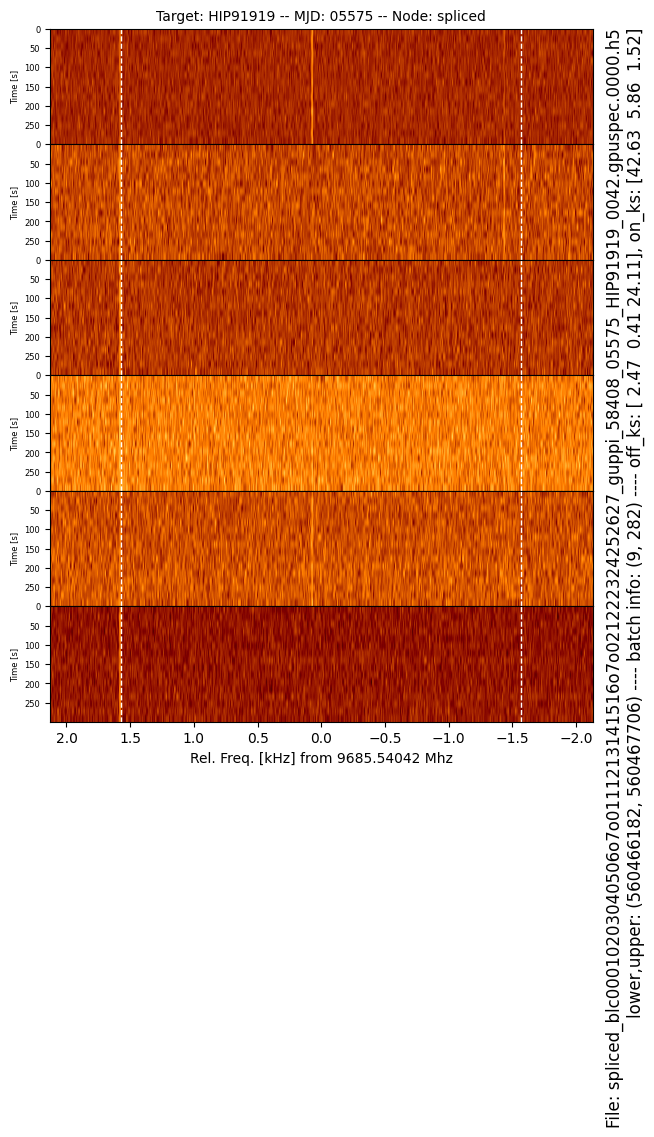

All Files            ['/datag/pipeline/AGBT18B_999_38/collate0/spli...
Index                                                         525831.0
Block Size                                                        1024
Freq                                                       9747.050284
obs1 maxes           [0.74496543, 0.8726696, 0.84294707, 0.93040514...
obs3 maxes           [0.8882526, 0.89000875, 0.90638816, 0.9084676,...
obs5 maxes           [0.8742513, 0.8542187, 0.804465, 0.89382195, 0...
ON_freq_int          [array([492.242  , 492.35535, 493.87296, 493.9...
k1                                                            3.084116
k2                                                            0.054047
k3                                                            0.157329
k4                                                            0.050765
k5                                                           10.374625
k6                                                            0.130498
k_scor

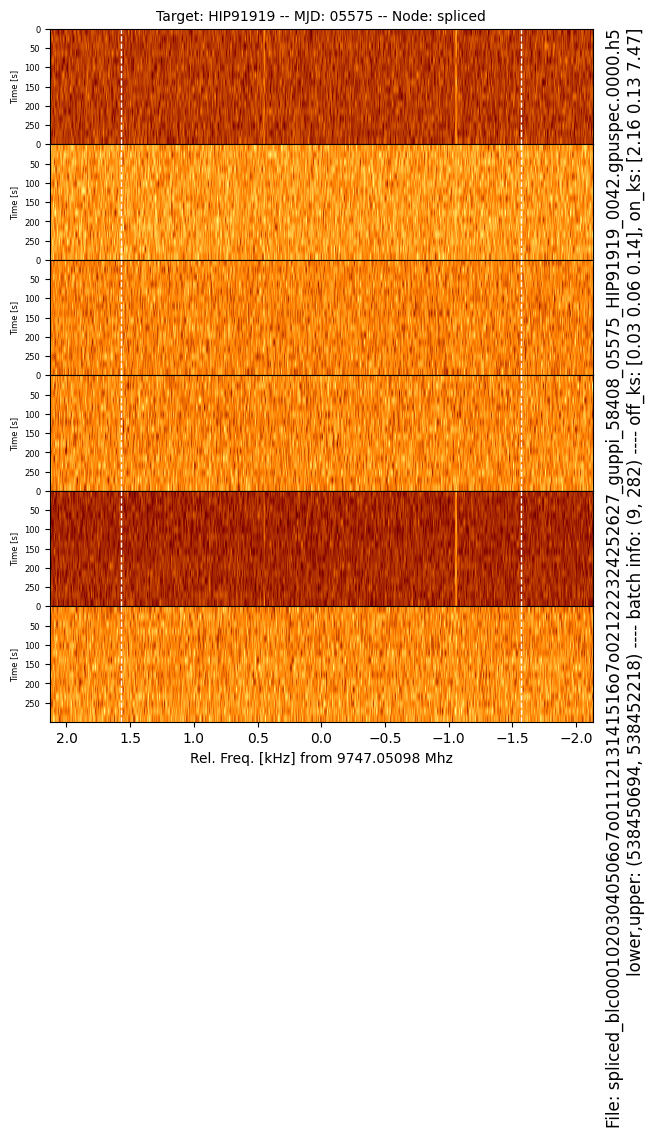

All Files            ['/datag/pipeline/AGBT18B_999_38/collate0/spli...
Index                                                         528903.0
Block Size                                                        1024
Freq                                                       9738.261221
obs1 maxes           [0.9760361, 0.8271818, 0.9073799, 0.9092835, 0...
obs3 maxes           [0.97215873, 0.9409272, 0.9542506, 0.98003834,...
obs5 maxes           [0.7979667, 0.7496703, 0.8771665, 0.8893132, 0...
ON_freq_int          [array([512.3225 , 515.39655, 514.3213 , 515.3...
k1                                                            3.628519
k2                                                            0.141254
k3                                                            0.049981
k4                                                            0.066666
k5                                                           16.090161
k6                                                            0.083994
k_scor

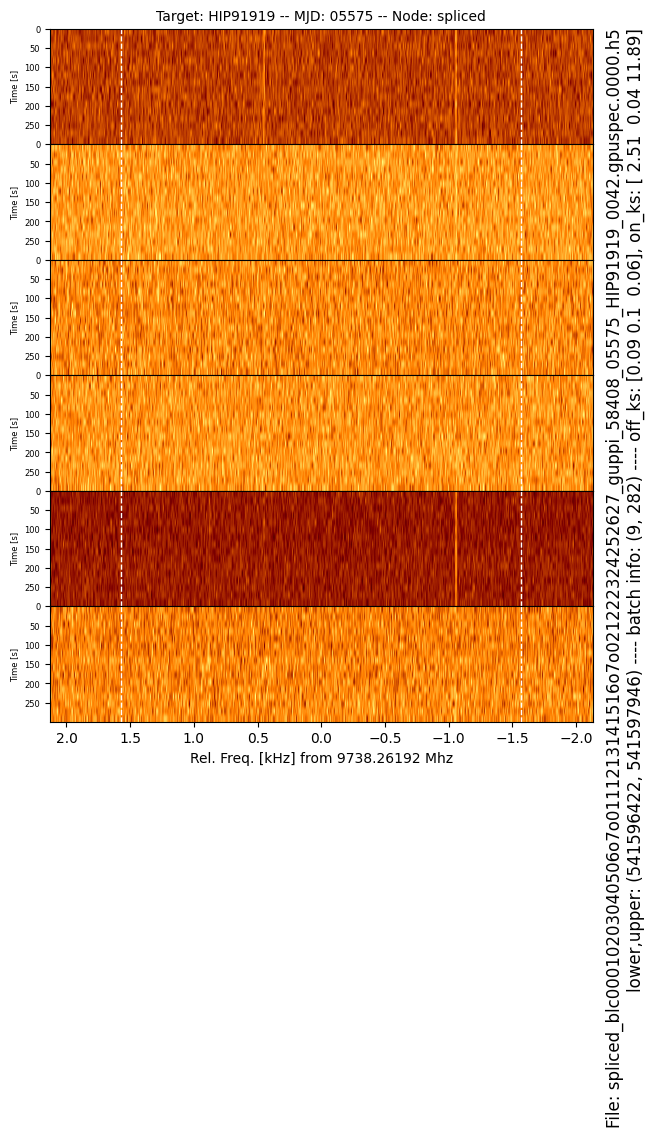

All Files            ['/datag/pipeline/AGBT18B_999_38/collate0/spli...
Index                                                         535032.0
Block Size                                                        1024
Freq                                                       9720.726012
obs1 maxes           [0.80183274, 0.8157273, 0.82527834, 1.0, 0.675...
obs3 maxes           [0.94136876, 0.9332828, 0.9790228, 0.93810236,...
obs5 maxes           [0.98643595, 0.7728932, 0.9057242, 0.8028819, ...
ON_freq_int          [array([514.28784, 518.0368 , 515.7866 , 516.6...
k1                                                            2.039266
k2                                                            0.045655
k3                                                            0.080523
k4                                                            0.073049
k5                                                            6.588883
k6                                                            0.179106
k_scor

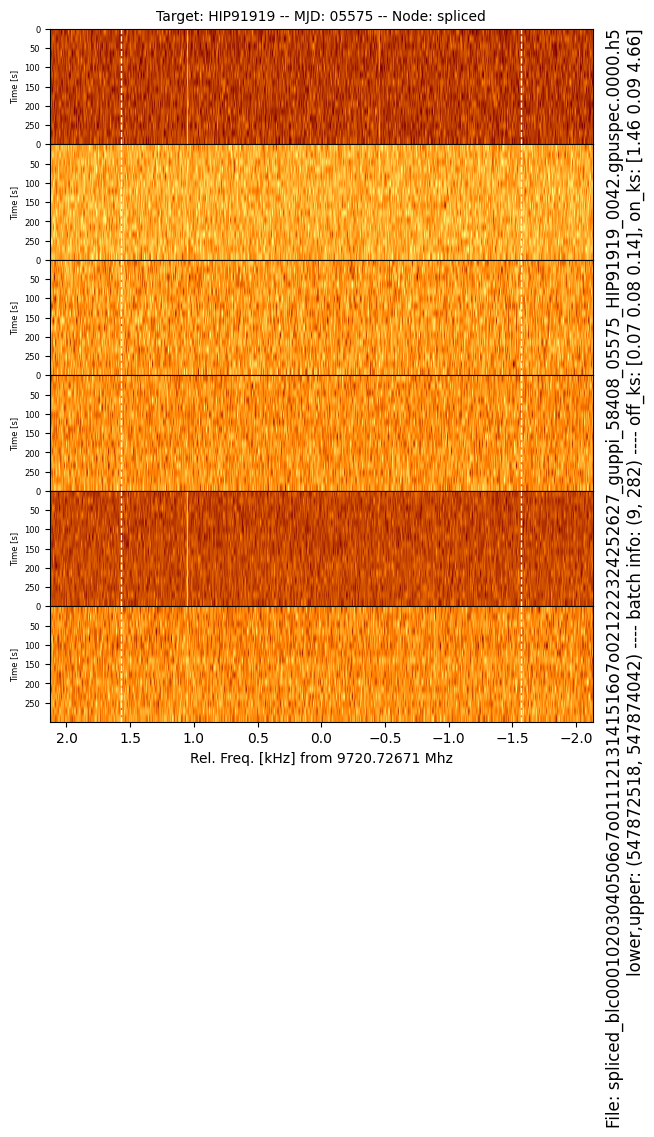

All Files            ['/datag/pipeline/AGBT18B_999_38/collate0/spli...
Index                                                         529927.0
Block Size                                                        1024
Freq                                                       9735.331534
obs1 maxes           [0.80400324, 0.7917295, 0.9492885, 0.7810261, ...
obs3 maxes           [0.93960226, 0.955263, 0.935619, 0.95456696, 0...
obs5 maxes           [0.78836143, 0.77276444, 0.69588095, 0.7129649...
ON_freq_int          [array([543.6131 , 543.6206 , 544.65375, 545.0...
k1                                                              2.1476
k2                                                            0.171834
k3                                                            0.079448
k4                                                            0.029859
k5                                                           11.478739
k6                                                            0.165694
k_scor

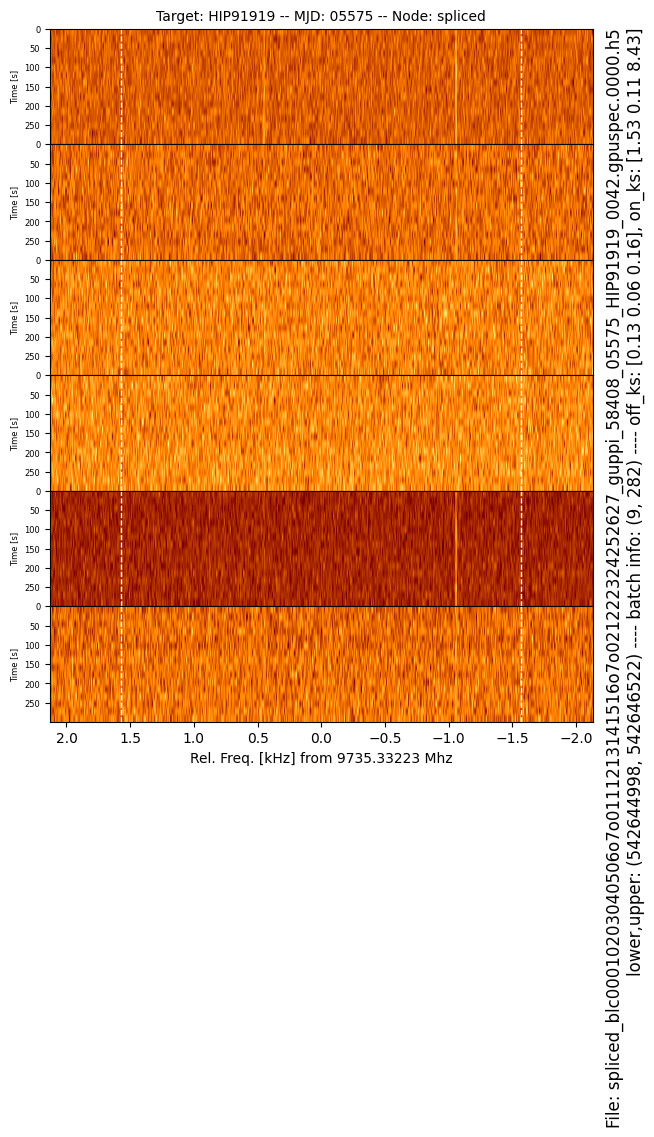

In [31]:
substrings = [eval(obs_hits.iloc[20][0])[0]]


mask = low_off_outliers['All Files'].str.contains(substrings[0], case=False, na=False)
for substring in substrings[1:]:
    mask = mask & low_off_outliers['All Files'].str.contains(substring, case=False, na=False)

low_off_outliers_filtered = low_off_outliers[mask]
print(len(low_off_outliers_filtered))

for i in range(0,5):
    print(low_off_outliers_filtered.iloc[i])
    single_plot_wrapper(i,low_off_outliers_filtered)

In [7]:
# check what observations are missing
with open('/datax/scratch/calebp/pickles/missing', 'rb') as f:
    missing_obs_all = pickle.load(f)
    missing_obs_all[87] = [-1]

with open('/datax/scratch/calebp/pickles/contained', 'rb') as f:
    contained_obs_all = pickle.load(f)
    contained_obs_all[87] = [-1]


In [8]:
lengths_missing = [len(x) for x in missing_obs_all]
lengths_contained = [len(x) for x in contained_obs_all]

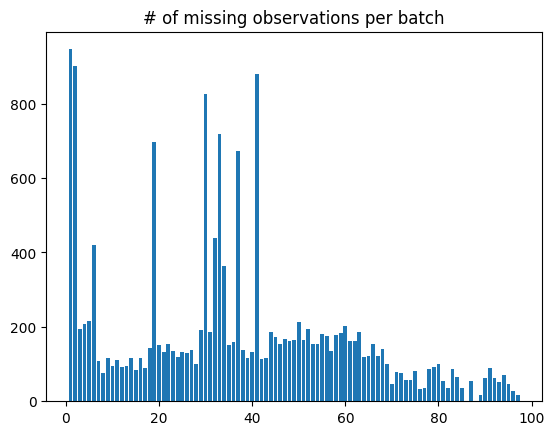

<BarContainer object of 97 artists>

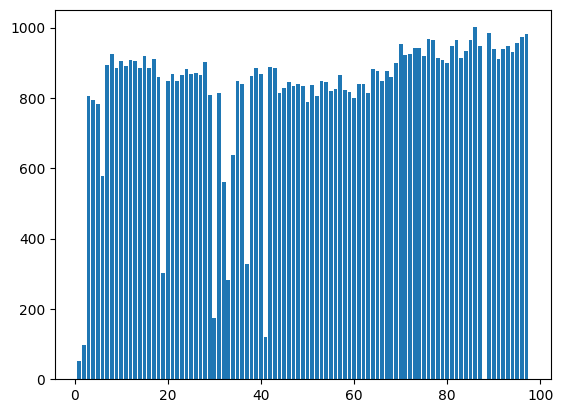

In [9]:
plt.bar(np.arange(1,98,1),lengths_missing)
plt.title("# of missing observations per batch")
plt.show()
plt.bar(np.arange(1,98,1),lengths_contained)


## Promising Candidates

In [39]:
# grab candidates from finder
numbers = [531,
 307,
 133,
 170,
 150,
 274,
 212,
 239,
 111,
 233,
 120,
 153,
 49,
 116,
 107,
 293,
 217,
 108,
 312,
 221,
 965,
 259,
 141,
 90,
 2,
 238,
 257,
 262,
 962,
 316,
 283,
 267,
 964,
 152,
 218,
 254,
 118,
 134,
 279,
 333,
 263,
 564,
 248,
 560,
 961,
 55,
 145,
 335,
 202,
 161,
 113,
 530,
 544,
 224,
 268,
 284,
 171,
 106,
 701,
 1033,
 571,
 548,
 249,
 135,
 143,
 140,
 1032,
 119,
 260,
 309,
 269,
 542,
 1058,
 264,
 288]

In [42]:
# load the dataframe of candidates 
csv_file = "/datax/scratch/calebp/k_scores/SORTED_FILTERED_LOW_OUTLIERS_OFF_25_ON_5.csv"
all_outliers = pd.read_csv(csv_file)

In [45]:
most_promising = all_outliers.iloc[numbers]

peaks [987] [994] [979]
[7] [15] [8]


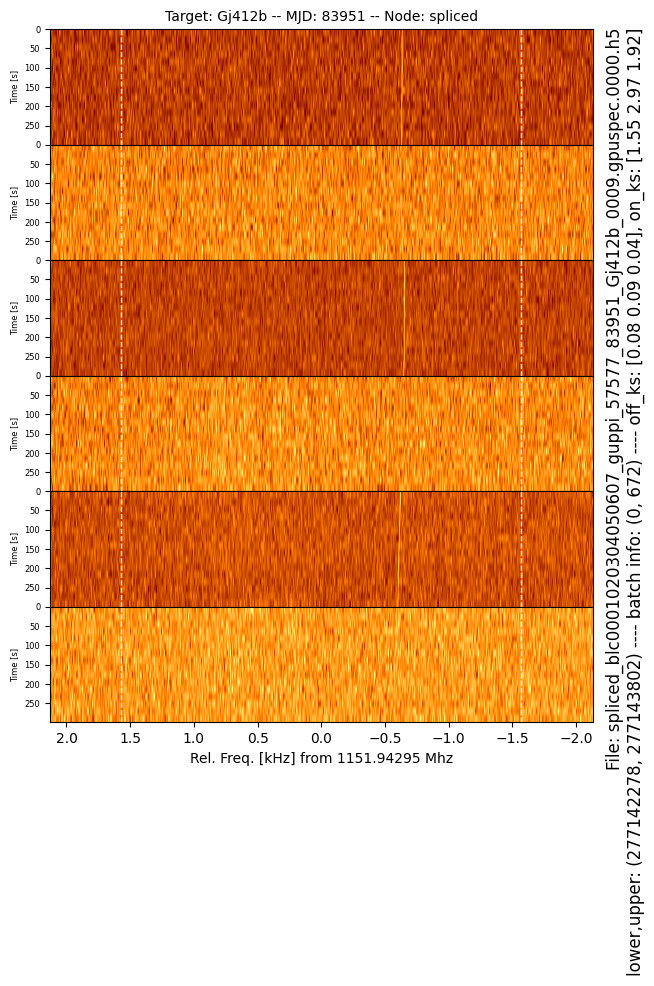

In [70]:
single_plot_wrapper(0,most_promising)

In [75]:
len(set(list(most_promising["All Files"])))

25

(array([270., 432., 178., 337., 308., 552., 142., 214., 156.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,  23.,  97.,   2.,  11.,   2.,
         14.,   4.,   3.,   3.,   8.,   0.,   4.,   0.,   1.,   2.,   9.,
         57., 155.,   3.,  83.,   1.,  15., 119., 118.,  84.,  78.,  64.,
         48., 241.,  33., 105.,   0.,   9.]),
 array([ 1101.04465345,  1292.71456579,  1484.38447813,  1676.05439046,
         1867.7243028 ,  2059.39421514,  2251.06412748,  2442.73403982,
         2634.40395216,  2826.07386449,  3017.74377683,  3209.41368917,
         3401.08360151,  3592.75351385,  3784.42342618,  3976.09333852,
         4167.76325086,  4359.4331632 ,  4551.10307554,  4742.77298788,
         4934.44290021,  5126.11281255,  5317.78272489,  5509.45263723,
         5701.12254957,  5892.79246191,  6084.46237424,  6276.13228658,
         6467.80219892,  6659.47211126,  6851.1420236 ,  7042.81193594,
         7234.48184827,  7426.15176061,  7617.82167295,  7809.49158529,
         8

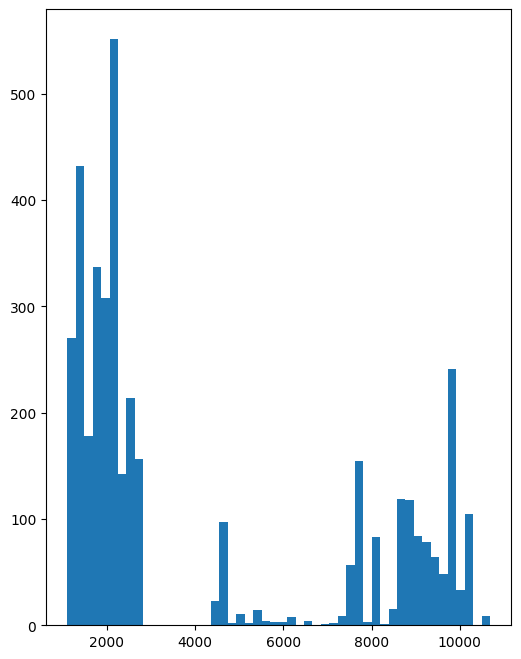

In [81]:
plt.hist(list(all_outliers['Freq']),bins=50)

## All Block Statistics

In [7]:
with open('/datax/scratch/calebp/k_scores/ALL_BATCHES.pkl', 'rb') as f:
    master_list = pickle.load(f)

In [9]:
master_k_table = pd.DataFrame(master_list)
print(len(master_k_table))

23688878


In [10]:
master_k_table.head()

All Files   Index  Block Size  \
0  ['/datag/pipeline/AGBT16A_999_08/holding/splic...  4540.0        1024   
1  ['/datag/pipeline/AGBT16A_999_08/holding/splic...  4540.5        1024   
2  ['/datag/pipeline/AGBT16A_999_08/holding/splic...  5549.0        1024   
3  ['/datag/pipeline/AGBT16A_999_08/holding/splic...  5549.5        1024   
4  ['/datag/pipeline/AGBT16A_999_08/holding/splic...  5602.5        1024   

          Freq                                         obs1 maxes  \
0  1913.087389  [0.90008885, 0.89960194, 0.99211913, 0.7940033...   
1  1913.085938  [0.90008885, 0.89960194, 0.99211913, 0.7940033...   
2  1910.157702  [0.8431608, 0.97488534, 0.84178734, 0.80157006...   
3  1910.156250  [0.8431608, 0.97488534, 0.84178734, 0.80157006...   
4  1910.002362  [0.85678655, 0.94428945, 0.86844593, 0.8585740...   

                                          obs3 maxes  \
0  [0.95909363, 0.8121421, 0.9242945, 0.9130977, ...   
1  [0.95909363, 0.8121421, 0.9242945, 0.9130977, ...   
2  [0.010805881, 0.011949246, 0.009759651, 0.0113...   
3  [0.010805881, 0.011949246, 0.009759651, 0.0113...   
4  [0.87717056, 0.92090136, 0.79565334, 0.9257043...   

                                          obs5 maxes  \
0  [0.8488397, 0.768606, 0.869409, 0.87574214, 0....   
1  [0.8488397, 0.768606, 0.869409, 0.87574214, 0....   
2  [0.94553864, 0.938584, 0.908449, 1.0, 0.946194...   
3  [0.94553864, 0.938584, 0.908449, 1.0, 0.946194...   
4  [0.8757953, 0.8533554, 0.8979615, 0.89325494, ...   

                                         ON_freq_int         k1            k2  \
0  [array([317.42554, 320.011  , 320.44586, 313.6...  70.067602  16298.264992   
1  [array([317.76318, 319.65475, 320.60748, 313.9...  71.760551  16298.167979   
2  [array([332.61288, 333.95486, 336.00522, 328.8...  50.112212  14981.121546   
3  [array([332.16525, 334.64014, 335.4279 , 327.7...  49.453534  14982.102347   
4  [array([528.244  , 533.01294, 532.49554, 525.6...   2.177657      0.951612   

   ...   k_score      min_k      med_k        max_k  drift1  drift2  \
0  ...  0.013194  70.067602  72.144283    74.798187     0.0   False   
1  ...  0.013365  71.760551  73.825485    74.233939     0.0    True   
2  ...  0.433389  50.112212  51.112704  6440.805197     0.0   False   
3  ...  0.433312  49.453534  50.531847  6440.942060     0.0    True   
4  ...  1.658980   1.932526   2.047583     2.177657     0.0   False   

   Batch Info  blip or broadband      new_k     off_k_sum  
0      (0, 0)               None  72.144283  16448.131314  
1      (0, 0)               None  73.825485  16447.612887  
2      (0, 0)               None  51.112704  15095.070177  
3      (0, 0)               None  50.531847  15095.192257  
4      (0, 0)               None   2.047583      3.711779  

[5 rows x 24 columns]

In [12]:
files_list = master_k_table["All Files"]

In [27]:
unique_files = Counter(files_list).keys() # equals to list(set(words))
regions_per_obs = Counter(files_list).values() # counts the elements' frequency

all_freqs = master_k_table["Freq"]

In [30]:
np.mean(list(regions_per_obs))

383.94265709330784

In [37]:
bad_regions = [[1160,1340],[1370,1390],[1520,1630],[1670,1705],[1915,2000],[2025,2035],[2100,2120],[2180,2280],[2300,2360],[2485,2500],[2800,4400],[4680,4800],[8150,8350],[9550,9650],[10700,12000]]


In [12]:
all_freqs_table = master_k_table[(abs(master_k_table["k2"])<.25)&(abs(master_k_table["k4"])<.25)&(abs(master_k_table["k6"])<.25)&(abs(master_k_table["med_k"])>.5)]

all_freqs = np.array(all_freqs_table["Freq"])

In [144]:
all_freqs_outliers = np.array(low_off_outliers["Freq"])

In [145]:
len(all_freqs_outliers)

11233

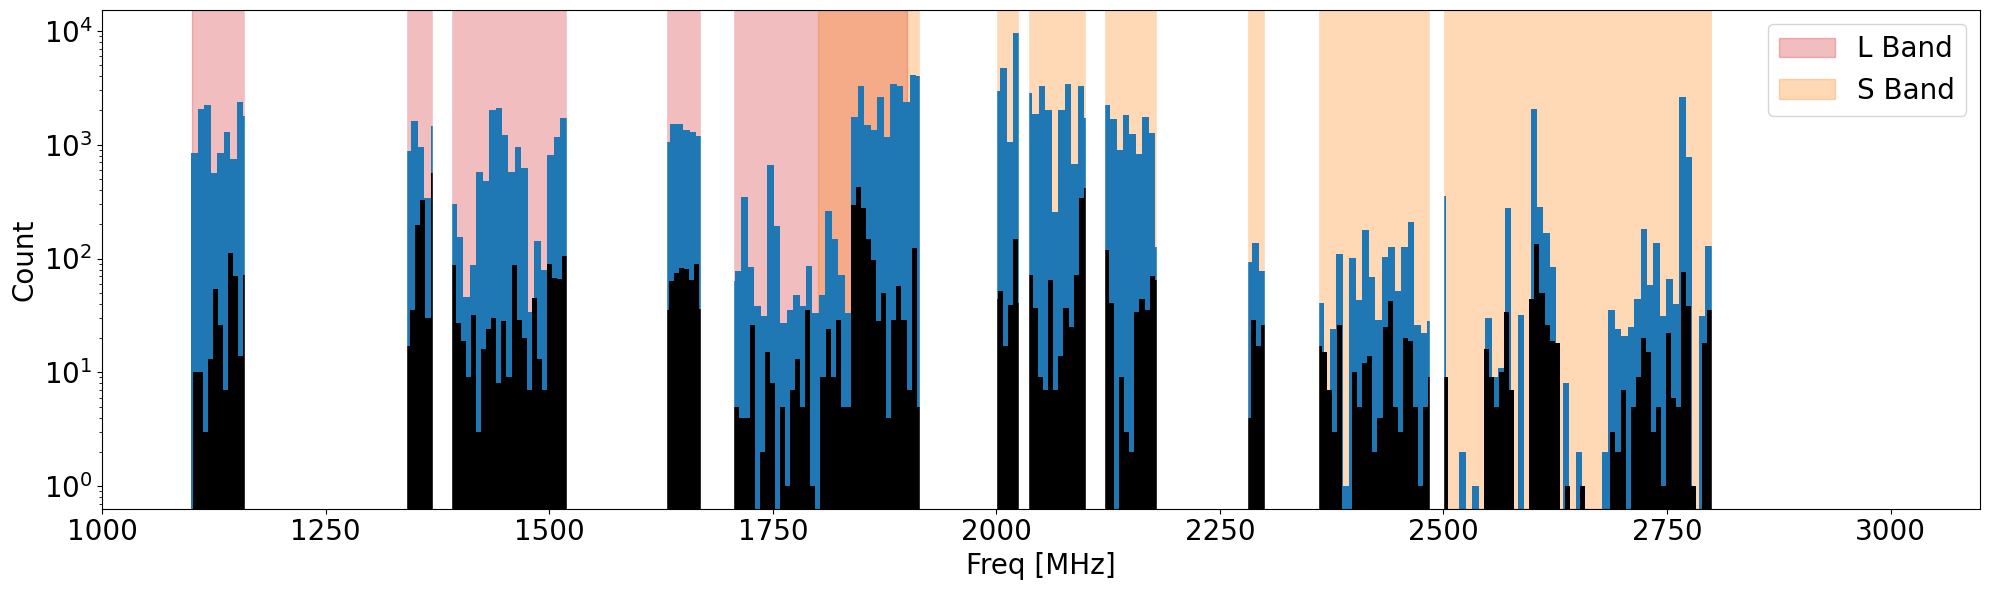

In [149]:
plt.figure(figsize=(20,6))

textsize = 20

plt.axvspan(1100,1900,color='tab:red',label='L Band',alpha=.3)
plt.axvspan(1800,2800,color='tab:orange',label='S Band',alpha=.3)

plt.hist(all_freqs[all_freqs < 4000],bins=300,color='tab:blue')
plt.hist(all_freqs_outliers[all_freqs_outliers < 4000],bins=300,color='black')


# plt.axvspan(4000,7800,color='tab:green',label='C Band',alpha=.3)
# plt.axvspan(7800,11200,color='tab:blue',label='X Band',alpha=.3)

plt.legend(loc='upper right',fontsize=textsize)
plt.yscale('log')

plt.xticks(fontsize=textsize)
plt.yticks(fontsize=textsize)

plt.xlabel('Freq [MHz]',fontsize=textsize)
plt.ylabel('Count',fontsize=textsize)

plt.xlim(1000,3100)

for i in bad_regions:
    plt.axvspan(i[0],i[1],color='white',alpha=1)

plt.tight_layout()
plt.savefig('/mnt_blpc1/datax/scratch/calebp/k_scores/freq_dist_L_S.png')
plt.show()


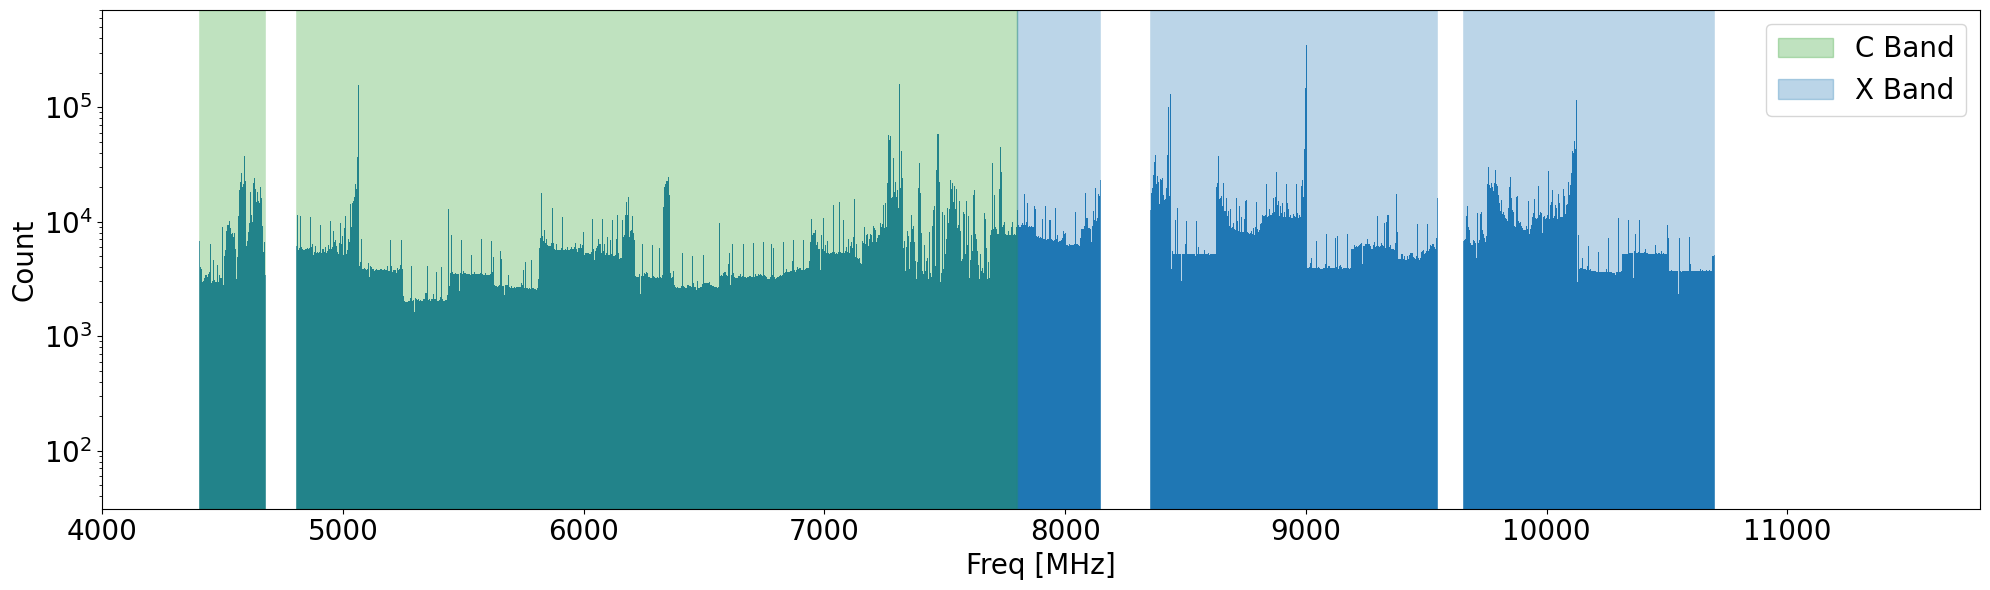

In [88]:
plt.figure(figsize=(20,6))
plt.hist(all_freqs[all_freqs > 4000],bins=2000)

# plt.axvspan(1100,1900,color='tab:red',label='L Band',alpha=.3)
# plt.axvspan(1800,2800,color='tab:orange',label='S Band',alpha=.3)

plt.axvspan(4000,7800,color='tab:green',label='C Band',alpha=.3)
plt.axvspan(7800,11200,color='tab:blue',label='X Band',alpha=.3)

plt.legend(loc='upper right',fontsize=textsize)
plt.yscale('log')

plt.xticks(fontsize=textsize)
plt.yticks(fontsize=textsize)

plt.xlabel('Freq [MHz]',fontsize=textsize)
plt.ylabel('Count',fontsize=textsize)

plt.xlim(4000,11800)

for i in bad_regions:
    plt.axvspan(i[0],i[1],color='white',alpha=1)

plt.tight_layout()
plt.savefig('/mnt_blpc1/datax/scratch/calebp/k_scores/freq_dist_X_C.png')
plt.show()


In [64]:
# with open('/datax/scratch/calebp/k_scores/all_unique_file_names.pkl', 'wb') as file:
#     pickle.dump(unique_files, file)

In [62]:
## look at file distances

ras = []
decs = []
targets = []
fch1s = []
foffs = []
nchans = []

for file in tqdm(unique_files[0:100]):
    hf_ON = h5py.File(eval(file)[0], 'r')
    fch1, foff, nchan, ra, decl, target = get_file_properties(hf_ON)
    ras.append(ra); decs.append(decl);targets.append(target);fch1s.append(fch1);foffs.append(foff);nchans.append(nchan)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.98it/s]


In [75]:
#  df = pd.DataFrame({
#     'RA': ras,
#     'DEC': decs,
#     'Target': targets,
#     'fch1': fch1s,
#     'foffs': foffs,
#     'nchans': nchans
#     })
# df.to_csv('/datax/scratch/calebp/k_scores/test_all_file_infos_ra_dec.pkl')

In [134]:
L_band_all_infos = all_file_infos[all_file_infos['fch1'] < 1900]

In [138]:
L_band_names = get_names(L_band_all_infos["Target"])

In [141]:
obs_per_target = Counter(L_band_names)

In [142]:
obs_per_target

Counter({'TIC305550963': 57,
         'HIP20901': 37,
         'HIP19855': 20,
         'HIP20261': 19,
         'HIP21272': 19,
         'TIC240450679': 19,
         'HIP19859': 19,
         'HIP20219': 19,
         'SexA': 17,
         'TIC198153540': 15,
         'HIP12114': 15,
         'HIP112527': 15,
         'HIP13258': 15,
         'HIP12832': 15,
         'HIP12929': 15,
         'HIP57866': 15,
         'HIP13601': 15,
         'TIC138294130': 14,
         'SO0253': 13,
         'TIC427153307': 12,
         'HIP38931': 12,
         'TIC366311757': 11,
         'NGC4489': 10,
         'NGC1400': 10,
         'HIP115147': 10,
         'Maffei2': 10,
         'HIP18267': 10,
         'MESSIER86': 10,
         'TIC153951307': 10,
         'Dw1': 10,
         'TIC417948359': 10,
         'Maffei1': 10,
         'NGC720': 10,
         'And_II': 10,
         'HIP46853': 9,
         'TIC81593515': 9,
         'TIC144297844': 9,
         'TIC266688542': 9,
         'TIC198241702': 9,

In [140]:
len(list(set(L_band_names)))

1855

In [46]:
bands = all_file_infos['fch1']

In [131]:
L_S_band = bands[bands<4000]

(array([ 6444.,  7876.,   663.,  2476.,  4917.,  3726.,  7984., 10806.,
        10981.,  5826.]),
 array([  866.03515485,  1904.57812374,  2943.12109263,  3981.66406152,
         5020.20703041,  6058.7499993 ,  7097.29296819,  8135.83593708,
         9174.37890597, 10212.92187486, 11251.46484375]),
 <BarContainer object of 10 artists>)

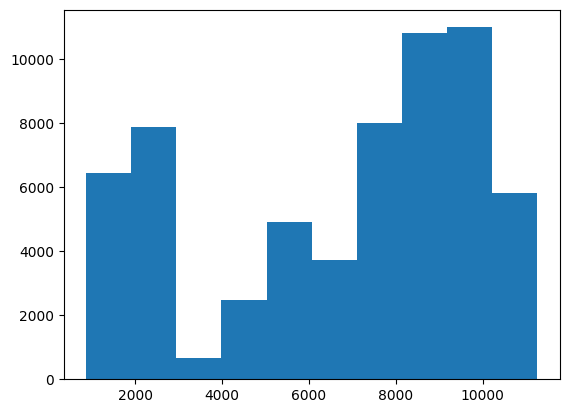

In [136]:
plt.hist(bands)

(array([  62., 1000.,  988., 1950., 2444., 2628., 1482., 1085., 1345.,
        1336.,  586.,   77.,    0.,    0.,    0.,    0.,    0.,  617.,
         615., 1244., 1229.,  616., 1233.,  610., 1229., 1224.,  631.,
         612.,  633.,  626., 1247., 1856.,  915., 1997., 1969., 2149.,
        1788., 1364., 2743., 2762., 2745., 1368., 1381., 2735., 2752.,
        1372., 1370., 1374., 1381.,  329.]),
 array([  866.03515485,  1073.74374863,  1281.45234241,  1489.16093619,
         1696.86952996,  1904.57812374,  2112.28671752,  2319.9953113 ,
         2527.70390508,  2735.41249885,  2943.12109263,  3150.82968641,
         3358.53828019,  3566.24687397,  3773.95546774,  3981.66406152,
         4189.3726553 ,  4397.08124908,  4604.78984286,  4812.49843663,
         5020.20703041,  5227.91562419,  5435.62421797,  5643.33281175,
         5851.04140552,  6058.7499993 ,  6266.45859308,  6474.16718686,
         6681.87578064,  6889.58437441,  7097.29296819,  7305.00156197,
         7512.71015575, 

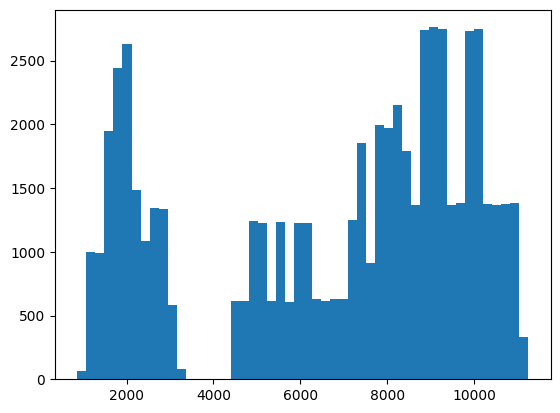

In [48]:
plt.hist(bands,bins=50)

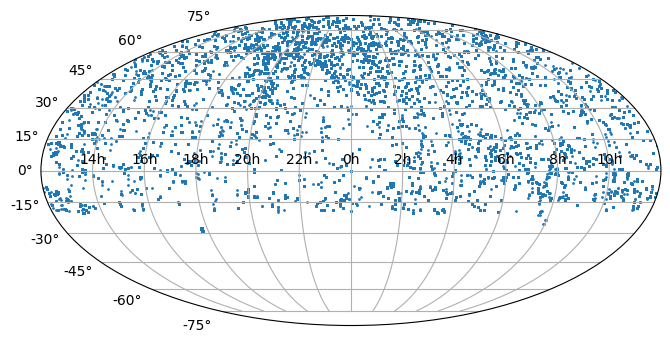

In [178]:
# load all file statistics
all_file_infos = pd.read_csv('/datax/scratch/calebp/k_scores/all_file_infos_ra_dec2.csv')

ras = all_file_infos["RA"]
decs = all_file_infos["DEC"]


ras = Angle(ras*15 * u.degree,unit='deg')
decs = Angle(decs * u.degree,unit='deg')

# Wrap the RA at 180 degrees and convert to radians for plotting
ras = ras.wrap_at(180 * u.degree).radian

# Ensure declinations are in radians too
decs = decs.radian
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="mollweide")
ax.scatter(ras, decs,s=1)
ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])
ax.grid(True)

In [14]:
def extract_within_quotes(lst):
    results = []
    for string in lst:
        # Find all occurrences of text within single quotes
        matches = re.findall(r"'(.*?)'", string)
        results.extend(matches)  # Use extend to add all items from the list matches
    return results

In [16]:
all_targets = all_file_infos['Target']
names = extract_within_quotes(all_targets)

In [137]:
def get_names(all_targets):
    nas = []
    for t in list(all_targets):
        if t[0] == 'b' and t[1] == "'":
            nas.append(t[2:-1])
        else:
            nas.append(t)

    return nas

In [176]:
with open("/datax/scratch/calebp/k_scores/all_file_parallaxes3.pkl", 'rb') as f:
    plxs = pickle.load(f)

parallaxes = plxs[1]
distances = [1/(.001 * x) for x in parallaxes]

count = 0
actual_plxs = []
for x in parallaxes:
    if x > 0:
        count += 1
        actual_plxs.append(x)

distances = np.array([1/(.001 * x) for x in actual_plxs])

Text(0, 0.5, 'Number')

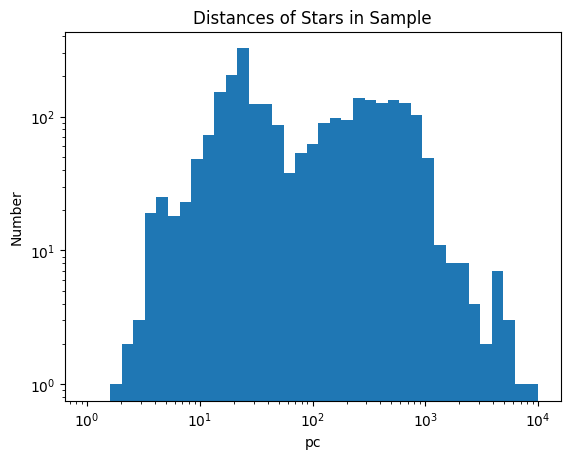

In [177]:
bins = np.logspace(0,4,40)
plt.hist(distances,bins=bins,log=True)
plt.title("Distances of Stars in Sample")
plt.xlabel("pc")
plt.xscale('log')
plt.ylabel("Number")

In [50]:
with open("/datax/scratch/calebp/k_scores/all_outlier_snrs_run_final.pkl", 'rb') as handle:
    stuff = pickle.load(handle)


Text(0, 0.5, 'Number')

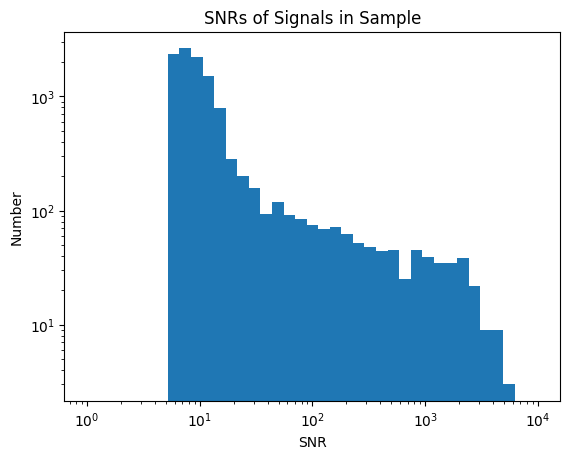

In [174]:
np.logspace(0,4,20)
snrs_final = np.array(stuff)
bins = np.logspace(0,4,40)
plt.hist(snrs_final,bins=bins,log=True)
plt.title("SNRs of Signals in Sample")
plt.xlabel("SNR")
plt.xscale('log')
plt.ylabel("Number")

## EIRP calculations

In [179]:
# L band

snr_min = 10
sefd = 10 # in Jansky
del_v = 3 # in Hz
n_pol = 2
t_obs = 300 # in seconds

v_tot = 455 # Mhz
v_mid = 1500 # Mhz

N_stars = 1855
num_obs_per_star = 2
d = 50 * 3.086e16 # distance in meters



S_min = snr_min * sefd * np.sqrt(del_v / (n_pol*t_obs*num_obs_per_star))

EIRP = 4 * np.pi * d**2 * S_min * 10**-26

eta_AO_L = ((10**13)/500)**(-1)

TFM = eta_AO_L * EIRP * (1/N_stars) * (v_mid / v_tot)

print(f"L Band Minimum Sensitivity: {S_min} Jansky")
print(f"L Band EIRP {EIRP:.2e} W")
print(f"L Band TFM {TFM:.2e} W")



L Band Minimum Sensitivity: 5.0 Jansky
L Band EIRP 1.50e+12 W
L Band TFM 1.33e-01 W
